In [34]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf

In [35]:
df = pd.read_csv(r'C:\Users\nico_\Desktop\series_temporelles\AEP_hourly.csv')

In [36]:
df["Datetime"] = pd.to_datetime(df["Datetime"])

In [37]:
df = df.sort_values(by="Datetime")

In [38]:
df = df.set_index('Datetime')

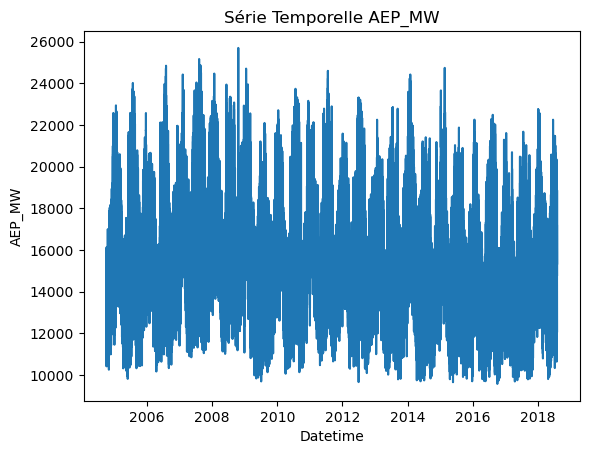

In [39]:
plt.plot(df.index, df['AEP_MW'])
plt.xlabel('Datetime')
plt.ylabel('AEP_MW')
plt.title('Série Temporelle AEP_MW')
plt.show()

In [40]:
df2 = df.resample('M').mean()

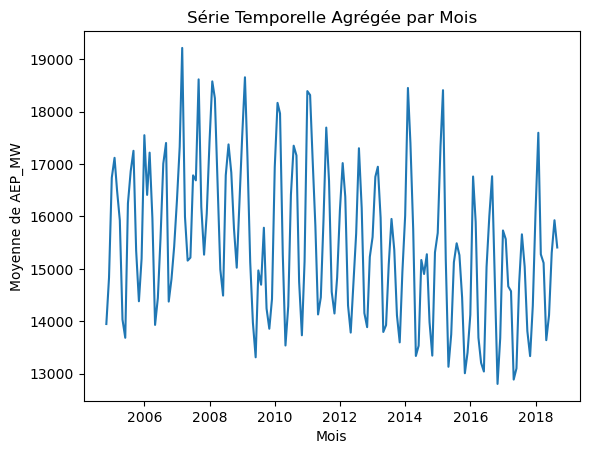

In [41]:
plt.plot(df2.index, df2['AEP_MW'])
plt.xlabel('Mois')
plt.ylabel('Moyenne de AEP_MW')
plt.title('Série Temporelle Agrégée par Mois')
plt.show()

In [42]:
split_time = (len(df2["AEP_MW"]) * 70)/100
split_time

116.9

In [43]:
split_time = 116

# Train
time_train = df2.index[:split_time]
x_train = df2["AEP_MW"][:split_time]

# Validation
time_val = df2.index[split_time:]
x_val = df2["AEP_MW"][split_time:]

In [44]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train.values.reshape(-1, 1))

x_val_scaled = scaler.transform(x_val.values.reshape(-1, 1))

In [45]:
window_size = 20
batch_size = 32
shuffle_buffer_size = 100

In [46]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer_size):
    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(window_size +1, shift = 1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(window_size +1))
    dataset = dataset.map(lambda window: (window[:-1],window[-1]))
    dataset = dataset.shuffle(shuffle_buffer_size)
    dataset = dataset.batch(batch_size).prefetch(1)
    
    return dataset

In [47]:
dataset = windowed_dataset(x_train_scaled, window_size, batch_size, shuffle_buffer_size)

In [48]:
# Reset states generated by Keras
tf.keras.backend.clear_session()

# Build the model
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [49]:
lr_schedule = tf.keras.callbacks.LearningRateScheduler(lambda epoch: 1e-8 * 10**(epoch / 20))

optimizer = tf.keras.optimizers.SGD(momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(), optimizer=optimizer)

history = model.fit(dataset, epochs=200, callbacks=[lr_schedule])

Epoch 1/200
3/3 [==============================] - 13s 82ms/step - loss: 0.9296 - lr: 1.0000e-08
Epoch 2/200
3/3 [==============================] - 0s 22ms/step - loss: 0.9295 - lr: 1.1220e-08
Epoch 3/200
3/3 [==============================] - 0s 25ms/step - loss: 0.9293 - lr: 1.2589e-08
Epoch 4/200
3/3 [==============================] - 0s 22ms/step - loss: 0.9291 - lr: 1.4125e-08
Epoch 5/200
3/3 [==============================] - 0s 21ms/step - loss: 0.9287 - lr: 1.5849e-08
Epoch 6/200
3/3 [==============================] - 0s 21ms/step - loss: 0.9285 - lr: 1.7783e-08
Epoch 7/200
3/3 [==============================] - 0s 21ms/step - loss: 0.9280 - lr: 1.9953e-08
Epoch 8/200
3/3 [==============================] - 0s 25ms/step - loss: 0.9274 - lr: 2.2387e-08
Epoch 9/200
3/3 [==============================] - 0s 21ms/step - loss: 0.9269 - lr: 2.5119e-08
Epoch 10/200
3/3 [==============================] - 0s 21ms/step - loss: 0.9263 - lr: 2.8184e-08
Epoch 11/200
3/3 [====================

(1e-08, 0.1, 0.0, 200.0)

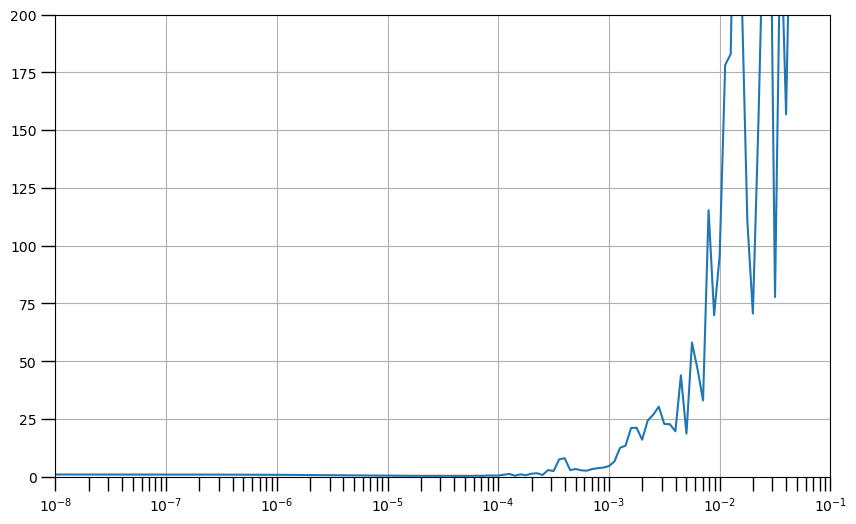

In [52]:
lrs = 1e-8 * (10 ** (np.arange(200) / 20))

plt.figure(figsize=(10, 6))

plt.grid(True)

plt.semilogx(lrs, history.history["loss"])

plt.tick_params('both', length=10, width=1, which='both')

plt.axis([1e-8, 1e-1, 0, 200])

loss: 0.3381 - lr: 2.5119e-05

In [53]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Lambda(lambda x: tf.expand_dims(x, axis=-1),
                      input_shape=[None]),
   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 100.0)
])

In [54]:
# Set the learning rate
learning_rate = 2e-6

# Set the optimizer
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)

In [55]:
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

In [56]:
history = model.fit(dataset,epochs=1000)

Epoch 1/1000
3/3 [==============================] - 10s 79ms/step - loss: 2.8144 - mae: 3.2755
Epoch 2/1000
3/3 [==============================] - 0s 22ms/step - loss: 2.8028 - mae: 3.2634
Epoch 3/1000
3/3 [==============================] - 0s 21ms/step - loss: 2.7845 - mae: 3.2461
Epoch 4/1000
3/3 [==============================] - 0s 23ms/step - loss: 2.7546 - mae: 3.2155
Epoch 5/1000
3/3 [==============================] - 0s 22ms/step - loss: 2.7247 - mae: 3.1842
Epoch 6/1000
3/3 [==============================] - 0s 22ms/step - loss: 2.6893 - mae: 3.1490
Epoch 7/1000
3/3 [==============================] - 0s 23ms/step - loss: 2.6553 - mae: 3.1140
Epoch 8/1000
3/3 [==============================] - 0s 22ms/step - loss: 2.6175 - mae: 3.0752
Epoch 9/1000
3/3 [==============================] - 0s 21ms/step - loss: 2.5782 - mae: 3.0356
Epoch 10/1000
3/3 [==============================] - 0s 20ms/step - loss: 2.5425 - mae: 2.9986
Epoch 11/1000
3/3 [==============================] - 0s 22

In [57]:
def model_forecast(model, series, window_size, batch_size):

    # Generate a TF Dataset from the series values
    dataset = tf.data.Dataset.from_tensor_slices(series)

    # Window the data but only take those with the specified size
    dataset = dataset.window(window_size, shift=1, drop_remainder=True)

    # Flatten the windows by putting its elements in a single batch
    dataset = dataset.flat_map(lambda w: w.batch(window_size))
    
    # Create batches of windows
    dataset = dataset.batch(batch_size).prefetch(1)
    
    # Get predictions on the entire dataset
    forecast = model.predict(dataset)
    
    return forecast

In [58]:
df2["AEP_MW_scaled"] = scaler.fit_transform(df2['AEP_MW'].values.reshape(-1, 1))

In [59]:
def plot_series(time, series, format="-", start=0, end=None):
    """
    Visualizes time series data

    Args:
      time (array of int) - contains the time steps
      series (array of int) - contains the measurements for each time step
      format - line style when plotting the graph
      start - first time step to plot
      end - last time step to plot
    """

    # Setup dimensions of the graph figure
    plt.figure(figsize=(10, 6))

    if type(series) is tuple:

      for series_num in series:
        # Plot the time series data
        plt.plot(time[start:end], series_num[start:end], format)

    else:
      # Plot the time series data
      plt.plot(time[start:end], series[start:end], format)

    # Label the x-axis
    plt.xlabel("Time")

    # Label the y-axis
    plt.ylabel("Value")

    # Overlay a grid on the graph
    plt.grid(True)

    # Draw the graph on screen
    plt.show()

2/2 [==============================] - 2s 49ms/step


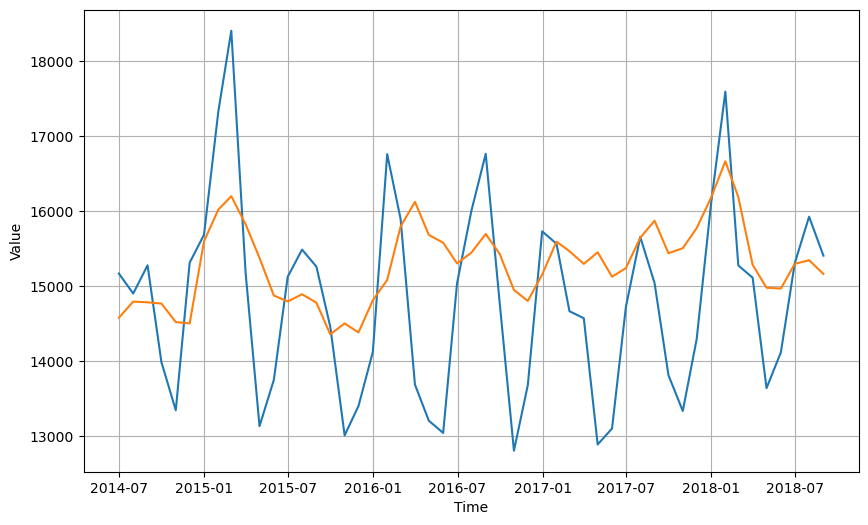

In [60]:
# Reduce the original series
forecast_series = df2['AEP_MW_scaled'][split_time-window_size:-1]

# Use helper function to generate predictions
forecast = model_forecast(model, forecast_series, window_size, batch_size)

# Drop single dimensional axis
results = forecast.squeeze()
results = results.reshape(-1, 1)
results_original = scaler.inverse_transform(results)

# Plot the results
plot_series(time_val, (x_val, results_original))

In [61]:
mse = tf.keras.metrics.mean_squared_error(x_val, results_original).numpy()
mae = tf.keras.metrics.mean_absolute_error(x_val, results_original).numpy()

In [62]:
print("Mean Squared Error (MSE) Mean:", np.mean(mse))
print("Mean Absolute Error (MAE) Mean:", np.mean(mae))

Mean Squared Error (MSE) Mean: 2114603.8
Mean Absolute Error (MAE) Mean: 1166.2189
